In [22]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from transformers import get_scheduler
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
import spacy


# Load Dataset and Dicts

In [43]:
from datasets import load_dataset
# arbitrarily chosen by stack overflow reccomendation
dataset = load_dataset('snli')
dataset = load_dataset("generics_kb", "generics_kb_best")
dataset['train'] = dataset['train'].select(np.random.permutation(dataset['train'].shape[0])[:4000] )

In [23]:
nlp = spacy.load("en_core_web_sm")  # Smaller model suitable for CPU

In [ ]:
def reduce_tag(tag):
    # NEED TO DO
    reduce_tag = tag
    return reduce_tag

In [36]:
# tag is what defines the syntax of the sentence, right now it is just a compilation of the POS tags
def get_tag(sentence):
    tag = []
    #logic for getting tag
    for w in nlp(sentence):
        if not w.is_stop:
            tag.append((w.pos_))
            # all relevant attribute
            # tag.append((w.pos_, w.tag_, w.dep_,))
            # print(w.text, w.pos_, w.tag_, w.dep_, w.is_stop)
    # need to implement intelligent reduction of tag so that some are similar
    # tag = reduce(tag)
    return tuple(tag)



In [37]:
get_tag("The quick brown fox jumps over the lazy dog")

('ADJ', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'NOUN')

In [38]:

def create_tag_to_sentence_dict(dataset):
    tag_to_sentence_dict = defaultdict(list)
    for sentence in dataset['train']['generic_sentence']:
        tag = get_tag(sentence)
        tag_to_sentence_dict[tag].append(sentence)

    return tag_to_sentence_dict

In [44]:
tag_to_sentence_dict = create_tag_to_sentence_dict(dataset)

In [45]:
similar_tags = []
for tag, sentences in tag_to_sentence_dict.items():
   similar_tags.append(len(sentences))

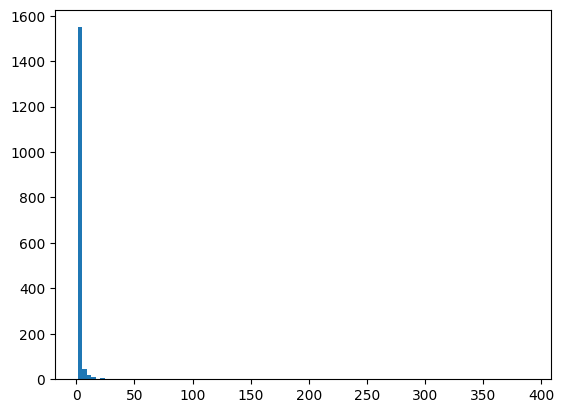

In [46]:
import matplotlib.pyplot as plt
plt.hist(similar_tags, bins=100)
plt.show()

# Create label(POS,dependency graph,...) to sentence


In [4]:
from transformers import DistilBertModel, DistilBertTokenizer
# arbitrarily chosen light weight BERT version
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [5]:
def tokenize_function(examples):
    # Tokenize the input sentences and keep the original texts
    tokenized_inputs = tokenizer(examples['generic_sentence'], padding="max_length", truncation=True, max_length=128)
    tokenized_inputs['original_sentences'] = examples['generic_sentence']
    return tokenized_inputs


In [12]:
# Apply the tokenizer to the input text
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 10331.17 examples/s]


# Define Model


In [ ]:
class Siamese_Syntax_BERT(nn.Module):
    def __init__(self, model):
        super(Siamese_Syntax_BERT, self).__init__()
        self.bert = model

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        output1 = self.bert(input_ids1, attention_mask=attention_mask1)[1]  # Only take [CLS] token embedding
        output2 = self.bert(input_ids2, attention_mask=attention_mask2)[1]
        
        return output1, output2



# Create Dataloaders

In [14]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)#.select(range(10000))  # Subset for training
eval_dataset = tokenized_datasets["train"].shuffle(seed=42)#.select(range(10000, 12000))  # Subset for evaluation

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)


# Train

In [15]:
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

/opt/homebrew/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

In [ ]:
def create_pairs(original_sentences):
    syntactically_similar_pairs = []
    syntactically_dissimilar_pairs = []

    for original_sentence in original_sentences:
        # tag = get_tag(original_sentence)
        # choose random syntactically similar sentence

        # random_similar_sentence = random.choice(tag_to_sentences[tag])
        # syntactically_similar_pairs.append(random_similar_sentence)

        # choose random syntactically dissimilar sentence
        # random_similar_sentence = random.choice(tag_to_sentences[random.choice(list(tag_to_sentences.keys()))])
        # syntactically_dissimilar_pairs.append(random_dissimilar_sentence)
        
        return tokenize_function(syntactically_similar_pairs), tokenize_function(syntactically_dissimilar_pairs)
        

In [18]:
# Activate training mode
model.train()
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        input_ids = batch['input_ids']#.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        attention_mask = batch['attention_mask']#.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        original_sentences = batch['original_sentences']
        
        
        print("Original Sentences:", original_sentences)
        # Proceed with your model training steps
        # outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # loss = outputs.loss
        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()

    # Similarly for eval_dataloader in evaluation loop



        
        # # Backpropagation
        # loss.backward()
        # optimizer.step()
        # lr_scheduler.step()
        # optimizer.zero_grad()
        # progress_bar.update(1)

        # #EVAL
        # model.eval()
        # total_eval_loss = 0
        # num_eval_steps = 0

        # for batch in eval_dataloader:
        #     batch = {k: v.to(device) for k, v in batch.items()}
        #     with torch.no_grad():
        #         outputs = model(**batch)

        #     loss = outputs.loss
        #     total_eval_loss += loss.item()
        #     num_eval_steps += 1

        # avg_eval_loss = total_eval_loss / num_eval_steps
        # print(f"Average evaluation loss: {avg_eval_loss:.4f}")


  0%|          | 0/750 [00:04<?, ?it/s]


Original Sentences: ['Absentmindedness is preoccupation.', 'Abscess is one of two disorders in which fibroblasts proliferate to form scar.', 'Abdominal obesity is particularly dangerous .', 'Abortion is a form of minor surgery which, like all surgery, has certain risks.', 'Aardvarks are classified as omnivores, but they are far more specialized than that.', 'Most aardvarks eat first solid food.', 'Abortion is used as a means of birth control, to space or limit the number of births.', 'Aboriginals are massively over-represented in the long list of victims of crime.']
Original Sentences: ['Abortion is the ultimate in selfishness.', 'Abbeys have (part) readsides.', 'Abortion is the termination or ending of a pregnancy after implantation.', 'Abortion is a choice that many women make when facing an unplanned pregnancy.', 'Some aardvarks eat fruit.', 'Aardwolves are solitary and nocturnal, and rest in burrows during the day.', 'Abrasive cutoff saws separate material by grinding.', 'Abortion 